# v8 Draft notebook:  HEASARC access through python
In this notebook, we go through a specific science case with a number of examples for accessing HEASARC data, including catalogs, images and spectra, using various VO protocols. The various services are described on the __[HEASARC VO](https://heasarc.gsfc.nasa.gov
/docs/archive/vo/)__ page. In summary:

* [1. VOTable](#votable): [Accessing](#votable1) and [creating](#votable2) VOTables
* [2. SCS](#scs):  Using the Simple Cone Search to query a different catalog in a loop
* [3. SIA](#sia): Using the Simple Image Access protocol.  
* [4a. TAP1](#tap1): Using the Table Access Protocol to find available VO resources
* [4b. TAP2](#tap2): Using the TAP to cross-correlate our objects with a catalog
* [4c. Combining data](#combo) from different catalogs
* [5. SSA](#ssa):  Using the Simple Spectral Access protocol to retrieve spectra.


## Notes:

There are a number of ways to use VO services through Python.  From the AstroQuery web page (https://astroquery.readthedocs.io/en/latest/):

<div class="alert alert-block alert-info">"There are two other packages with complimentary functionality as Astroquery: astropy.vo is in the Astropy core and pyvo is an Astropy affiliated package. They are more oriented to general virtual observatory discovery and queries, whereas Astroquery has web service specific interfaces."</div>
    
For this notebook, we will stick with the generic python requests method. In general, the queries are simple enough that this is almost as readable, and it has the benefit of depending on no specialized packages. There is as yet no single standardized set of Python tools for accessing VO data.  


In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy
## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")
## The main HTTP request tool we will use:
import requests
## For simple astropy tables
import astropy
import io
from IPython.display import Image, display

## For handling ordinary astropy Tables
from astropy.table import Table

## For handling VO table type objects
from astropy.io import votable as apvot

## For reading FITS files
import astropy.io.fits as apfits

<a id="votable"></a>
# 1. VOTable:  working with VO Table objects


The __[IVOA TAP document](http://www.ivoa.net/documents/TAP/20100327/REC-TAP-1.0.html)__ describes the Table Access Protocol (TAP) that consist of an HTTP request to a given TAP service URL formed in a particular language (ADQL in this case) to specify what you wish to search for. 

In this example, we show how to list, fetch and look at VO tables from the HEASARC archive and also how to create your own VO Table, which can be used to cross-correlate with other VO Tables (see examples [4a](#tap1) and [4b](#tap2) below). 




<a id="votable1"></a>

## 1.1 Retrieving a catalog as a VO Table

We can use W3Browse to get a HEASARC catalog as a VOTable object.  W3Browse can be used to retrieve tables in a number of formats, one of which is a VO Table.  

The requests package of python is a generic interface to web services.  The requests.get() method formats the given parameters for you and returns the results of the HTTP request in a useful object.  In this case, the result is a string containing the VOTable result.  The standard astropy.table package can read these:

In [4]:
params = {'name': 'rosmaster'}
r = requests.get('http://heasarc.gsfc.nasa.gov/cgi-bin/W3Browse/getvotable.pl', params=params)
#r.text

In [5]:
table=Table.read(io.BytesIO(r.content))

In [6]:
print(type(table))
table

<class 'astropy.table.table.Table'>


col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28
,deg,deg,deg,deg,,,,s,s,,MJD,MJD,,,,,,,,,,,,deg,d,d,
bytes16,float64,float64,float64,float64,bytes6,bytes2,bytes4,int32,int32,bytes10,float64,float64,bytes20,bytes16,bytes14,int32,bytes4,int16,int16,bytes120,int32,int16,int32,int16,int32,int32,int16
RH202299N00,49.3200,-85.5400,299.8517,-30.6815,HRI,N,MPE,36146,70000,RDF 4_2,50174.496192129598,50187.986747685201,RE J0317-853,BURLEIGH,MATTHEW,202299,n00,2,2,RE J0317-853,24302,6,7128,307,2163,2177,2900
RH202299A01,49.3200,-85.5400,299.8517,-30.6815,HRI,N,MPE,43683,70000,RDF 3_6,50324.742534722202,50377.477592592601,RE J0317-853,BURLEIGH,MATTHEW,202299,a01,2,2,RE J0317-853,24301,6,7128,162,2316,2369,2900
RP200594N00,151.8800,-85.0800,299.4192,-23.3707,PSPCB,N,MPE,4231,5000,RDF 3_4,48682.1389583333,48690.983333333301,HD 89499,FLEMING,THOMAS,200594,n00,2,2,HD 89499,17171,2,3532,66,648,657,2900
RH201328N00,107.9100,-84.4700,296.7740,-26.5072,HRI,N,MPE,2332,2000,RDF 3_4,48880.838020833296,48881.780729166698,HD 60102 AB,ZINNECKER,HANS,201328,n00,2,2,HD 60102 AB,22560,3,4268,215,850,851,2900
RH400876A01,193.9400,-83.3700,303.0651,-20.4994,HRI,N,GSFC,19075,20000,RDF 4_2,50702.423530092601,50735.172557870399,2EG J1248-8306 POS 3,HALPERN,JULES,400876,a01,4,2,2EG J1248-8306 POS 3,25116,7,2460,299,2699,2733,9999
RH400876N00,193.9400,-83.3700,303.0651,-20.4994,HRI,N,GSFC,1059,20000,RDF 4_0,50548.2425,50548.255474537,2EG J1248-8306 POS 3,HALPERN,JULES,400876,n00,4,2,2EG J1248-8306 POS 3,19808,7,2460,85,2543,2543,9999
RH400877A02,190.1700,-83.3600,302.6001,-20.4952,HRI,N,GSFC,19384,20000,RDF 4_2,50893.248460648101,50895.138969907399,2EG J1248-8306 POS 4,HALPERN,JULES,400877,a02,4,2,2EG J1248-8306 POS 4,24927,7,2460,90,2893,2895,9999
RH400877A01,190.1700,-83.3600,302.6001,-20.4952,HRI,N,GSFC,2363,20000,RDF 4_2,50735.5647916667,50735.574120370402,2EG J1248-8306 POS 4,HALPERN,JULES,400877,a01,4,2,2EG J1248-8306 POS 4,25115,7,2460,260,2733,2733,9999


<a id="votable2"></a>
## 1.2 Creating a VO Table from scratch

Alternatively, we can create a table from scratch using an array of values named whatever we want.  

There are several ways of doing this, and there are a few object layers here, which can be confusing.  There are standard astropy Table objects, there are votable Table objects, and there are votable VOTableFile objects that might contain multiple votable Tables. Though some things can be done with generic astropy Tables, other VO operations can only be done with VO Tables or VOTableFile objects.  

This is easiest to see with an example.  

In [7]:
##  Create a table with only two columns starting from an astropy Table:  
from astropy.table import Table as apTable
aptable=apTable(
    numpy.array([
            [19.0186,       46.7304],
            [20.2887,       40.4703],
            [125.886,       21.3377],
            [136.002,       21.9679],
            [141.057,       40.6372],
            [146.700,       22.0116],
            [148.785,       14.2922],
            [149.751,       17.8168],
            [175.039,       15.3270],
            [191.542,       30.7317],
            [194.913,       28.8959],
            [199.026,       41.5011],
            [206.577,       43.8511],
            [209.963,       38.1821],
            [213.556,       15.6214],
            [219.967,       42.7421],
            [226.693,       12.8502],
            [237.489,       20.8057],
            [241.519,       20.8014],
            [317.088,       18.2002],
            [329.235,       6.64845],
            [333.830,       37.3012] ]), 
    names=["RA","DEC"])
print(type(aptable))
print(aptable)


<class 'astropy.table.table.Table'>
   RA     DEC  
------- -------
19.0186 46.7304
20.2887 40.4703
125.886 21.3377
136.002 21.9679
141.057 40.6372
  146.7 22.0116
148.785 14.2922
149.751 17.8168
175.039  15.327
191.542 30.7317
194.913 28.8959
199.026 41.5011
206.577 43.8511
209.963 38.1821
213.556 15.6214
219.967 42.7421
226.693 12.8502
237.489 20.8057
241.519 20.8014
317.088 18.2002
329.235 6.64845
 333.83 37.3012


In [8]:
## Then convert this to a VOTableFile object.
votablefile = apvot.from_table(aptable)
print(type(votablefile))
## Which contains a nested set of RESOURCES
for r in votablefile.resources:
    ## And tables (in this case, only one of each)
    mytable=r
    for t in r.tables:
        print(t)


<class 'astropy.io.votable.tree.VOTableFile'>
        RA                DEC        
------------------ ------------------
19.018599999999999 46.730400000000003
20.288699999999999 40.470300000000002
           125.886 21.337700000000002
136.00200000000001            21.9679
141.05699999999999            40.6372
146.69999999999999 22.011600000000001
           148.785 14.292199999999999
           149.751 17.816800000000001
175.03899999999999             15.327
           191.542            30.7317
194.91300000000001 28.895900000000001
199.02600000000001 41.501100000000001
           206.577 43.851100000000002
209.96299999999999 38.182099999999998
213.55600000000001            15.6214
219.96700000000001 42.742100000000001
226.69300000000001 12.850199999999999
           237.489 20.805700000000002
241.51900000000001 20.801400000000001
317.08800000000002 18.200199999999999
329.23500000000001 6.6484500000000004
333.82999999999998 37.301200000000001


<a id="scs"></a>
# 2. SCS:  Using the Simple Cone Search to query a different catalog in a loop
The __[Simple Cone Search (SCS) protocol](http://www.ivoa.net/documents/latest/ConeSearch.html)__ is used to search a given table with a given position and radius, getting again a VOTable XML result.  

In our science example, <i> we might want to search what available information exists for our sources within different HEASARC catalogs. For example, were any of our sources observed by Chandra, XMM or ROSAT? </i> Below, we show the search for the table 'chanmaster', the master catalog of observed Chandra targets, with a search radius of 0.1 degrees. 

<a id="scs1"></a>
The SCS is quite straightforward:

In [9]:
# len(mytable['ra'])
for i in range(len(aptable)):
    params = {'table': 'chanmaster', 'RA': aptable[i]['RA'], 'DEC':aptable[i]['DEC'], 'SR':0.1}
    r = requests.get('https://heasarc.gsfc.nasa.gov/cgi-bin/vo/cone/coneGet.pl', params=params)
    table=Table.read(io.BytesIO(r.content))
    print(table)
               

obsid status name  ra dec time ... exposure type  pi public_date Search_Offset
                  deg deg mjd  ...    s                  mjd                  
----- ------ ---- --- --- ---- ... -------- ---- --- ----------- -------------
obsid status name  ra dec time ... exposure type  pi public_date Search_Offset
                  deg deg mjd  ...    s                  mjd                  
----- ------ ---- --- --- ---- ... -------- ---- --- ----------- -------------
obsid  status      name        ra    ... type    pi    public_date Search_Offset
                              deg    ...                   mjd                  
----- -------- ----------- --------- ... ---- -------- ----------- -------------
 7937 archived NGC2563-P14 125.81833 ...   GO Mulchaey       54461        4.7670
obsid status name  ra dec time ... exposure type  pi public_date Search_Offset
                  deg deg mjd  ...    s                  mjd                  
----- ------ ---- --- --- ---- ... -------- 

<a id="sia"></a>
# 3. SIA:  Using the Simple Image Access protocol.


The __[HEASARC VO](https://heasarc.gsfc.nasa.gov/docs/archive/vo/instructions.html#_accessing)__ page describes how to access SkyView images with the SIA protocol. But first, how do you know what sorts of images are available?

## 3.1:  Finding SkyView SIA resources from the NAVO directory with TAP

First, we can find out what SIA resources are available through HEASARC. These are listed in a registry at STScI which we can brows on-line at the __[NAVO Directory](http://vao.stsci.edu/keyword-search/)__.  Alternatively, we can search it using the__[IVOA Table Access Protocol](http://www.ivoa.net/documents/TAP/20100327/REC-TAP-1.0.html)__ (TAP). We submit an HTTP request to a given TAP service URL formed in a particular language (ADQL in this case) to specify what we wish to search for, in this case the HEASARC SIA resources: 

In [10]:
# Warning:  'query' is bizarrely case-sensitive:
tap_params = {
    "request":"doQuery",
    "lang":"ADQL",
    "query":"""
        select b.short_name,a.ivoid from rr.capability a 
        natural join rr.resource b 
        where a.cap_type='simpleimageaccess' and a.ivoid like 'ivo://nasa.heasarc%' 
        order by short_name;
    """
    }
r = requests.post('http://vao.stsci.edu/RegTAP/TapService.aspx/sync', data=tap_params)
table=Table.read(io.BytesIO(r.content))
table

short_name,ivoid
object,object
1420MHz,ivo://nasa.heasarc/skyview/1420mhz
2MASS,ivo://nasa.heasarc/skyview/2mass
408MHz,ivo://nasa.heasarc/skyview/408mhz
AKARI,ivo://nasa.heasarc/skyview/akari
ASCA,ivo://nasa.heasarc/ascamaster
ASCA/AGN,ivo://nasa.heasarc/tartarus
ASCASIS,ivo://nasa.heasarc/ascasis
BATSIG,ivo://nasa.heasarc/skyview/batsig
CDFS-LESS,ivo://nasa.heasarc/skyview/cdfs-less


<div class="alert alert-block alert-danger">
This would be useful as a function, e.g.,<br>
    astroquery.heasarc.list_sia_services()<br>
But then we have to resolve the SkyView SIA versus Xamin SIA ambiguity.
</div>

### 3.2 Using SIA to retrieve an image from SkyView:

Now we pick one of these catalogs, SwiftUVOT, and look for our sources.  See __[the SIA definition](http://www.ivoa.net/documents/WD/SIA/sia-20040524.html)__ for usage.  In short, you specify the central position, POS, the angular SIZE, and the NAXIS, i.e., the number of bins.  (SkyView will bin/interpolate as needed from the archive data.)  

In [11]:
pos='{},{}'.format(aptable[0]['RA'],aptable[0]['DEC'])
#  Note that there's currently a bug in the default interpolation 
#  method with this particular query, so we have to set it to 'LI' here.
params = {'survey': 'swiftuvot', 'POS': pos, 'SIZE':'0.03', "NAXIS":"300,300", "interpolation":"LI"}
r = requests.get('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl', params=params)
table=Table.read(io.BytesIO(r.content))
print(table.colnames)

['Survey', 'Ra', 'Dec', 'Dim', 'Size', 'Scale', 'Format', 'PixFlags', 'URL', 'LogicalName']


Extract the fields you're interested in, e.g., the URLs of the images made by skyview.  Note that specifying as we did SwiftUVOT, we get a number of different images, e.g., UVOT U, V, B, W1, W2, etc.  For each survey, there are two URLs, first the FITS IMAGE and second the JPEG:

In [12]:
###  Inside the table is a numpy record array that you can access like this, for example:
#print(table.array[4][8])
#  Or like this
print(table[4]['URL'])
### To download the FITS image itself:
print(table[5]['URL'])

b'https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1512585096273&return=FITS'
b'https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1512585096273&nofits=1&quicklook=jpeg&return=jpeg'


### Resulting image
You can display it in python by
(give it ~10 seconds to appear)


In [13]:
##  Note that there are bugs with some of these datasets, 
##  since they are new in SkyView.  Selecting the U-band image.
##  (The decode is needed in Python 3.5 because it comes back a byte type.)
display(Image(url=table['URL'][5].decode("utf-8")))

Or download the FITS image and display it with:

(This often errors off with a time out message.  Just try it again, possibly a couple of times.)

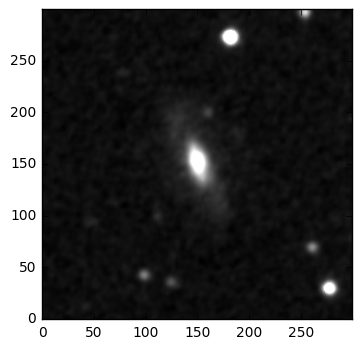

In [14]:
hdu_list=apfits.open(table['URL'][4].decode("utf-8"))
plt.imshow(hdu_list[0].data, cmap='gray', origin='lower',vmax=0.1)

<div class="alert alert-block alert-danger">
Why does it so frequently time out?
</div>

## Now with aplpy

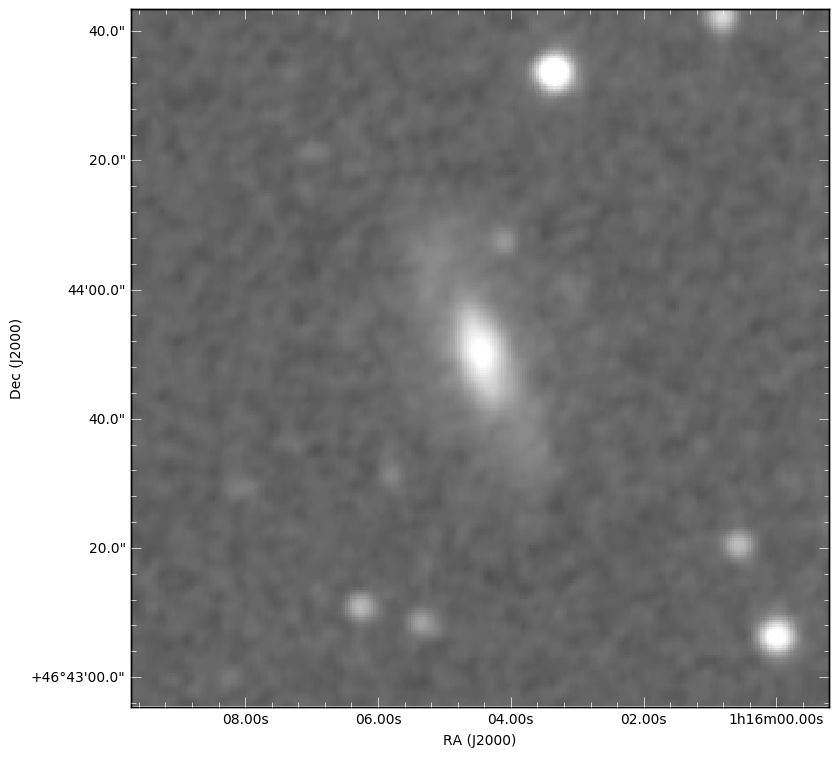

In [15]:
import aplpy
gc = aplpy.FITSFigure(hdu_list)
gc.show_grayscale(stretch='log', vmin=6e-3, vmax=1.4e-1)

### A related example with multiple VO interfaces
A very similar example uses the SkyView SIA protocol to retrieve an image from a different survey, SDSS, which is not held on the HEASARC SkyView server but at MAST.  In this case, the user is unaware of where the data come from, which is the point.  But under the hood, SkyView is using SIA to get the data from MAST.  

(Again, it will take a few seconds for the image to appear.)

In [16]:
params['survey']='sdssg'
r = requests.get('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl', params=params)

In [17]:
table=Table.read(io.BytesIO(r.content))
display(Image(url=table['URL'][1].decode("utf-8")))

<a id="tap1"></a>
# 4a. TAP:  Using the Table Access Protocol to find additional information on our sources
In this example, we already have a list of 30 sources from above.  We would now like to find their redshifts.

First, find out what catalogs HEASARC holds that might have redshifts:

In [18]:

tap_params["query"]="""
    select a.name,b.value
      from metainfo a, metainfo b
      where
         a.type='table' and b.type='table' and
         a.relation='defaultSearchRadius' and
         b.relation='description' and
         a.name=b.name and
         b.value LIKE '%Redshift%' 
      order by name    
      """
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params)
table=Table.read(io.BytesIO(r.content))
table

name,value
object,object
abellzcat,Abell Clusters Measured Redshifts Catalog
atlasspecz,AT Large Area Survey (ATLAS) Spectroscopic Classes & Redshifts Catalog
ccosmphotz,Chandra COSMOS (C-COSMOS) Survey Photometric Redshift Catalog
cfa2s,CfA Redshift Survey: South Galactic Cap Data
iraspscz,IRAS Point Source Catalog Redshift (PSCz) Catalog
iraszsurv,IRAS 1.2-Jy Redshift Survey
lcrscat,Las Campanas Redshift Survey Catalog
lowzvlqvla,VLA 6-GHz Observations of Low-Redshift SDSS QSOs
planckhzsc,Planck High-Redshift Source Candidates Catalog


<div class="alert alert-block alert-danger">
Wrap this, e.g., <br>
astroquery.heasarc.surveys_like("Redshift")<br>
<br>
Annoying case sensitive right now.  Can this be fixed?
</div>

We see that we can query these objects in the CfA Redshift Catalog, 'zcat'.  Since these are galaxies found in close pairs or groups, we might get multiple matches at each location. Let's first start with one object and search within 0.1 degree: 

In [19]:
##  Pick a radius in degrees to search around our input coordinates:
radius=0.1
tap_params = {
    "request":"doQuery",
    "lang":"ADQL",
    "query":
    """SELECT ra, dec, Radial_Velocity FROM zcat as cat where 
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',{0},{1},{2}))=1
    and Radial_Velocity > 0
    """.format(aptable[0]['RA'],aptable[0]['DEC'],radius)
    }
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params)
#r.content
table=Table.read(io.BytesIO(r.content))
table

ra,dec,radial_velocity
float64,float64,int32
19.068407270000002,46.740033570000001,5081
19.086435210000001,46.747227780000003,5188


<a id="tap2"></a>
# 4b. TAP:  Using the TAP to cross-correlate our objects with a catalog

Now to search all of the sources in one go, we need to upload our table and do a 'cross-correlation' of our own table with the 'zcat' table. Above, we had created a VOTableFile object called votablefile. Now we need to hand it to the requests method as upload data and use it in our TAP request.

First, create a "file-like" object that you can hand over:

In [20]:
## In memory only, use an IO stream. 
vot_obj=io.BytesIO()
apvot.writeto(votablefile,vot_obj)
## (Reset the "file-like" object to the beginning.)
vot_obj.seek(0)

## 'uplt' is what we'll call it (for 'upload table') 
##   in the requests parameters below, or what you will:
files={'uplt':vot_obj}

In [21]:
## Alternatively, write it to a file:
#apvot.writeto(votablefile, "new_votable.xml")
#files={'uplt':open('new_votable.xml', 'rb')}

In this case, we don't want to find all the associated galaxies, but just the match within 0.1 degree. 

(This takes a good 20 seconds.  If you need to rerun this cell, rerun the one above that defines the upload.  The IO object needs to be reset.) 

In [22]:
## These parameters are defined in the TAP standard.  
##  The string 'uplt' is what we set above as the name
##  of the parameter containing this data, and
##  the string 'mysources' is how we refer to it in 
##  the ADQL query string:
cc_params={
    'lang': 'ADQL', 
    'request': 'doQuery',
    'upload':'mysources,param:uplt'
    }
cc_params["query"]="""
    SELECT cat.ra, cat.dec, Radial_Velocity 
    FROM zcat cat, tap_upload.mysources mt 
    WHERE
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',mt.ra,mt.dec,0.1))=1
    and Radial_Velocity > 0
    ORDER by cat.ra"""
r = requests.post('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync',data=cc_params,stream=True,files=files)
mytable=Table.read(io.BytesIO(r.content))
mytable

ra,dec,radial_velocity
float64,float64,int32
19.068407270000002,46.740033570000001,5081
19.086435210000001,46.747227780000003,5188
20.334799289999999,40.487715479999999,5859
125.90444401000001,21.338192790000001,5219
125.90444401000001,21.338192790000001,5364
135.99423805999999,21.90099584,3157
136.00074370999999,21.96791867,3093
141.09150181000001,40.683784680000002,8267
146.70334308,22.018272169999999,7446


<a id="combo"></a>

# 4c. Another example with TAP table cross-correlation: Combining data from different catalogs
Now we'd like to take the redshift information (above, as a radial velocity) and determine a search radius to use for each galaxy based on its distance, so that we are are searching a given physical distance. Therefore we can address the science question: <i>are the redshifts (or radial velocities) of nearby (within 50 kpc physical distances) similar, suggesting these are truly "close" or potentially interacting galaxies?</i>

In [23]:
## The radial_velocity is in km/s, and this is just c*z, so
c=3.0e5 # km/s
redshifts=mytable['radial_velocity'].filled(0.)/c  # Filling masked values with zero
mytable['redshift']=redshifts
from astropy import units
physdist=0.05*units.Mpc # 50 kpc physical distance

## This needs scipy.  
from astropy.cosmology import Planck15
angDdist=Planck15.angular_diameter_distance(mytable['redshift'])
## angDdist is returned from the astropy.cosmology module as a Quantity object, 
##  i.e. a value and a unit.  Arctan is smart enough not to operate on quantities
##  that aren't unitless.  So angDdist.value to just get the value.
angDrad=numpy.arctan(physdist/angDdist)
angDdeg=angDrad*units.deg/units.rad
mytable['angDdeg']=angDdeg
mytable

ra,dec,radial_velocity,redshift,angDdeg
,,,,deg
float64,float64,int32,float64,float64
19.068407270000002,46.740033570000001,5081,0.0169366666667,0.000681042538686
19.086435210000001,46.747227780000003,5188,0.0172933333333,0.000667286051816
20.334799289999999,40.487715479999999,5859,0.01953,0.000592475054061
125.90444401000001,21.338192790000001,5219,0.0173966666667,0.000663405922543
125.90444401000001,21.338192790000001,5364,0.01788,0.00064585248346
135.99423805999999,21.90099584,3157,0.0105233333333,0.00108755212566
136.00074370999999,21.96791867,3093,0.01031,0.0011097660328
141.09150181000001,40.683784680000002,8267,0.0275566666667,0.000424005225996


<div class="alert alert-block alert-danger">
The above needs scipy.  That's just to use the cosmology package for the Planck15 specific computation of angular diameter distance.  Could simplify.
</div>


Now we're uploading a different file.  Need to reset the parameters with the table that has angDdist column.

In [24]:
## In memory only, use an IO stream. 
vot_obj=io.BytesIO()
print(mytable.columns)
apvot.writeto(apvot.from_table(mytable),vot_obj)
## (Reset the "file-like" object to the beginning.)
vot_obj.seek(0)
## 'uplt' is what we'll call it (for 'upload table') 
##   in the requests parameters below, or what you will:
files={'uplt':vot_obj}

<TableColumns names=('ra','dec','radial_velocity','redshift','angDdeg')>


In [25]:
## These are defined in the TAP standard:
cc_params={
    'lang': 'ADQL', 
    'request': 'doQuery',
    'upload':'mytable,param:uplt'
    }
## This is your ADQL query, where "mytable" here has to 
##  match what you specified in the upload parameter above
cc_params["query"]="""
    SELECT cat.ra, cat.dec, cat.Radial_Velocity 
    FROM zcat cat, tap_upload.mytable mt 
    WHERE
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',mt.ra,mt.dec,mt.angDdeg))=1
    and cat.Radial_Velocity > 0
    ORDER by cat.ra"""
## The name you give here (tab1) matches what's in the cc_params
r = requests.post('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync',data=cc_params,stream=True,files=files)
mytable=Table.read(io.BytesIO(r.content))
mytable

ra,dec,radial_velocity
float64,float64,int32
19.068407270000002,46.740033570000001,5081
19.086435210000001,46.747227780000003,5188
20.334799289999999,40.487715479999999,5859
125.90444401000001,21.338192790000001,5219
125.90444401000001,21.338192790000001,5219
125.90444401000001,21.338192790000001,5364
125.90444401000001,21.338192790000001,5364
135.99423805999999,21.90099584,3157
136.00074370999999,21.96791867,3093


<a id="ssa"></a>
# 6. SSA:  Using the Simple Spectral Access protocol to retrieve spectra.

<div class="alert alert-block alert-danger">
For now, a place-holder example with a Crab spectrum.  Replace if/when we find something scientifically interesting above with our galaxies.  
</div>

In [26]:
import astropy.coordinates as coord
crab=coord.SkyCoord.from_name("crab")
pos='{},{}'.format(crab.ra.deg,crab.dec.deg)
params = {'table': 'chanmaster',"POS":pos,"SIZE":".01", "REQUEST":"queryData"}
r = requests.get('https://heasarc.nasa.gov/xamin/vo/ssa', params=params)
spec_table = Table.read(io.BytesIO(r.content))
spec_table

obsid,status,name,ra,dec,time,detector,grating,exposure,type,pi,public_date,SSA_datalength,SSA_datamodel,SSA_title,SSA_instrument,SSA_publisher,SSA_tmid,SSA_stop_time,SSA_start_time,SSA_duration,SSA_bandpass,SSA_wavelength_max,SSA_wavelength_min,SSA_bandwidth,SSA_ra,SSA_dec,SSA_coord_obs,SSA_fov,SSA_reference,SSA_format
,,,deg,deg,mjd,,,s,,,mjd,,,,,,mjd,mjd,mjd,s,meter,meter,meter,meter,deg,deg,deg,deg,,
object,object,object,float64,float64,float64,object,object,float64,object,object,int32,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object
758,archived,CRAB PULSAR,83.63333,22.01444,51574.051800000001,HRC-S,LETG,100220,GO,Weisskopf,52026,2.0,Spectrum-1.0,hrcf00758N005_pha2,HRC-S,HEASARC,51574.642396415569,51575.232213349649,51574.051800000001,100220.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,83.633330000000001,22.01444,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao01/cat5/758/primary/hrcf00758N005_pha2.fits.gz,application/fits
759,archived,CRAB PULSAR,83.63333,22.01444,51576.438499999997,HRC-S,LETG,45430,GO,Weisskopf,51998,2.0,Spectrum-1.0,hrcf00759N005_pha2,HRC-S,HEASARC,51576.714687868312,51576.990141799048,51576.438499999997,45430.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,83.633330000000001,22.01444,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao01/cat5/759/primary/hrcf00759N005_pha2.fits.gz,application/fits
8548,archived,CRAB PULSAR,83.63333,22.01444,54369.4925,HRC-S,LETG,9130,GO,Weisskopf,54737,2.0,Spectrum-1.0,hrcf08548N003_pha2,HRC-S,HEASARC,54369.561003189585,54369.628743354864,54369.4925,9130.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,83.633330000000001,22.01444,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao01/cat5/8548/primary/hrcf08548N003_pha2.fits.gz,application/fits
9764,archived,CRAB PULSAR,83.63333,22.01444,54461.479200000002,HRC-S,LETG,3750,GO,Weisskopf,54828,2.0,Spectrum-1.0,hrcf09764N003_pha2,HRC-S,HEASARC,54461.512651364181,54461.545320274883,54461.479200000002,3750.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,83.633330000000001,22.01444,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao01/cat5/9764/primary/hrcf09764N003_pha2.fits.gz,application/fits
9765,archived,CRAB PULSAR,83.63333,22.01444,54487.664799999999,HRC-S,LETG,96170,GO,Weisskopf,54856,2.0,Spectrum-1.0,hrcf09765N003_pha2,HRC-S,HEASARC,54488.245868660182,54488.826206723614,54487.664799999999,96170.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,83.633330000000001,22.01444,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao01/cat5/9765/primary/hrcf09765N003_pha2.fits.gz,application/fits
3831,archived,CRAB PULSAR,83.63333,22.01444,52908.822,HRC-S,LETG,8830,GTO,Predehl,53277,2.0,Spectrum-1.0,hrcf03831N003_pha2,HRC-S,HEASARC,52908.885994156539,52908.949270707293,52908.822,8830.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,83.633330000000001,22.01444,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao04/cat5/3831/primary/hrcf03831N003_pha2.fits.gz,application/fits
169,archived,CRAB PULSAR,83.63333,22.01447,51603.010600000001,ACIS-S,HETG,8900,CAL,Calibration,51689,12.0,Spectrum-1.0,acisf00169N007_e2_pha2,ACIS-S,HEASARC,51603.079412616004,51603.147502751584,51603.010600000001,8900.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,83.633330000000001,22.014469999999999,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/cal/ao01/cat5/169/primary/acisf00169N007_e2_pha2.fits.gz,application/fits
169,archived,CRAB PULSAR,83.63333,22.01447,51603.010600000001,ACIS-S,HETG,8900,CAL,Calibration,51689,12.0,Spect

In [27]:
## Get the first spectrum (which has a long-ish exposure.)
import astropy.io.fits as fits
hdu_list=fits.open(spec_table[8]['SSA_reference'].decode()) # Byte format, so just decode() to string
#hdu_list.info()
table = Table(hdu_list[1].data)
table


SPEC_NUM,TG_M,TG_PART,TG_SRCID,X,Y,CHANNEL [8192],COUNTS [8192],STAT_ERR [8192],BACKGROUND_UP [8192],BACKGROUND_DOWN [8192],BIN_LO [8192],BIN_HI [8192]
int16,int16,int16,int16,float32,float32,int16,int16,float32,int16,int16,float64,float64
1,-3,1,1,4084.21,4107.53,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,7.15916666667 .. 0.333333333333,7.16 .. 0.334166666667
2,-2,1,1,4084.21,4107.53,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,10.73875 .. 0.5,10.74 .. 0.50125
3,-1,1,1,4084.21,4107.53,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,21.4775 .. 1.0,21.48 .. 1.0025
4,1,1,1,4084.21,4107.53,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,21.4775 .. 1.0,21.48 .. 1.0025
5,2,1,1,4084.21,4107.53,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,10.73875 .. 0.5,10.74 .. 0.50125
6,3,1,1,4084.21,4107.53,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,7.15916666667 .. 0.333333333333,7.16 .. 0.334166666667
7,-3,2,1,4084.21,4107.53,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,13.985 .. 0.333333333333,13.9866666667 .. 0.335
8,-2,2,1,4084.21,4107.53,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,20.9775 .. 0.5,20.98 .. 0.5025
9,-1,2,1,4084.21,4107.53,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,41.955 .. 1.0,41.96 .. 1.005


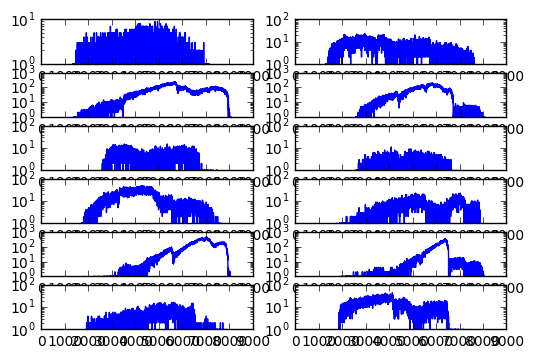

In [28]:
for i in range(len(table)):
    ax=plt.subplot(6,2,i+1)
    pha = plt.plot( table['CHANNEL'][i],table['COUNTS'][i])
    ax.set_yscale('log')

To download the spectrum for analysis with, e.g., Xspec:

In [31]:
import urllib
urllib.request.urlretrieve(spec_table[8]['SSA_reference'].decode(), "my_crab_spectrum.fits")

('my_crab_spectrum.fits', <http.client.HTTPMessage at 0x110a43b00>)